In [69]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import seaborn as sns
import pickle 

import torch
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from PIL import Image

In [ ]:
CELEB_REAL = 'Celeb-real'
YOUT_REAL = 'YouTube-real'
real_vid_paths = [os.path.join(CELEB_REAL, x) for x in os.listdir(CELEB_REAL)]
real_vid_paths.extend([os.path.join(YOUT_REAL, x) for x in os.listdir(YOUT_REAL)])
print(len(real_vid_paths))

In [ ]:
margin = 80
image_size = 150

# Load face detector
mtcnn = MTCNN(keep_all=False, select_largest=False, post_process=False,
              device=device, min_face_size=100,
              margin=margin, image_size=image_size).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [ ]:
OUT_DIR = 'faces'

In [ ]:
def extract_faces(frame, name):

    face = mtcnn(frame)
    if(face == None):
        return False
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.show()
    cv2.imwrite(os.path.join(OUT_DIR, f'{name}.png'), face.permute(1, 2, 0).int().numpy())
    return True

In [ ]:
def getFrames(path):
    name = os.path.basename(path).split('.')[0]
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    i = 0
    for frame_idx in range(int(frame_count)):
        i += 1
        # Get the next frame, but don't decode if we're not using it.
        ret = capture.grab()
        if(i < 200):
            continue
        if not ret: 
            print("Error grabbing frame %d from movie %s" % (frame_idx, path))
            
        ret, frame = capture.retrieve()
        if ret == False:
            break
            
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame)
        # plt.show()
        if(extract_faces(frame, name)):
            print(i)
            break
    
    capture.release()

In [ ]:
from torchvision.transforms import ToTensor

tf_img = lambda i: ToTensor()(i).unsqueeze(0)
embeddings = lambda input: resnet(input)

In [ ]:
face_files = [os.path.join(OUT_DIR, x) for x in os.listdir(OUT_DIR)]
print(len(face_files))
print(face_files[:5])

In [ ]:
list_embs = []
with torch.no_grad():
    for face in tqdm(face_files):
        t = tf_img(Image.open(face)).to(device)
        e = embeddings(t).squeeze().cpu().tolist()
        list_embs.append(e)

In [ ]:
df = pd.DataFrame({'face': face_files, 'embedding': list_embs})
df['video'] = df.face.apply(lambda x: f"{os.path.basename(x).split('.')[0]}.mp4")
df = df[['video', 'face', 'embedding']]

In [62]:
df.head()

video             face  \
0  00000.mp4  faces\00000.png   
1  00001.mp4  faces\00001.png   
2  00002.mp4  faces\00002.png   
3  00003.mp4  faces\00003.png   
4  00004.mp4  faces\00004.png   

                                           embedding  cluster  
0  [0.028108710423111916, -0.04008132591843605, -...        0  
1  [0.02548721618950367, 0.002130749635398388, -0...        1  
2  [0.032452136278152466, 0.008776827715337276, 0...        2  
3  [0.024423010647296906, 0.044686172157526016, -...        3  
4  [0.059661585837602615, 0.06588483601808548, -0...        4

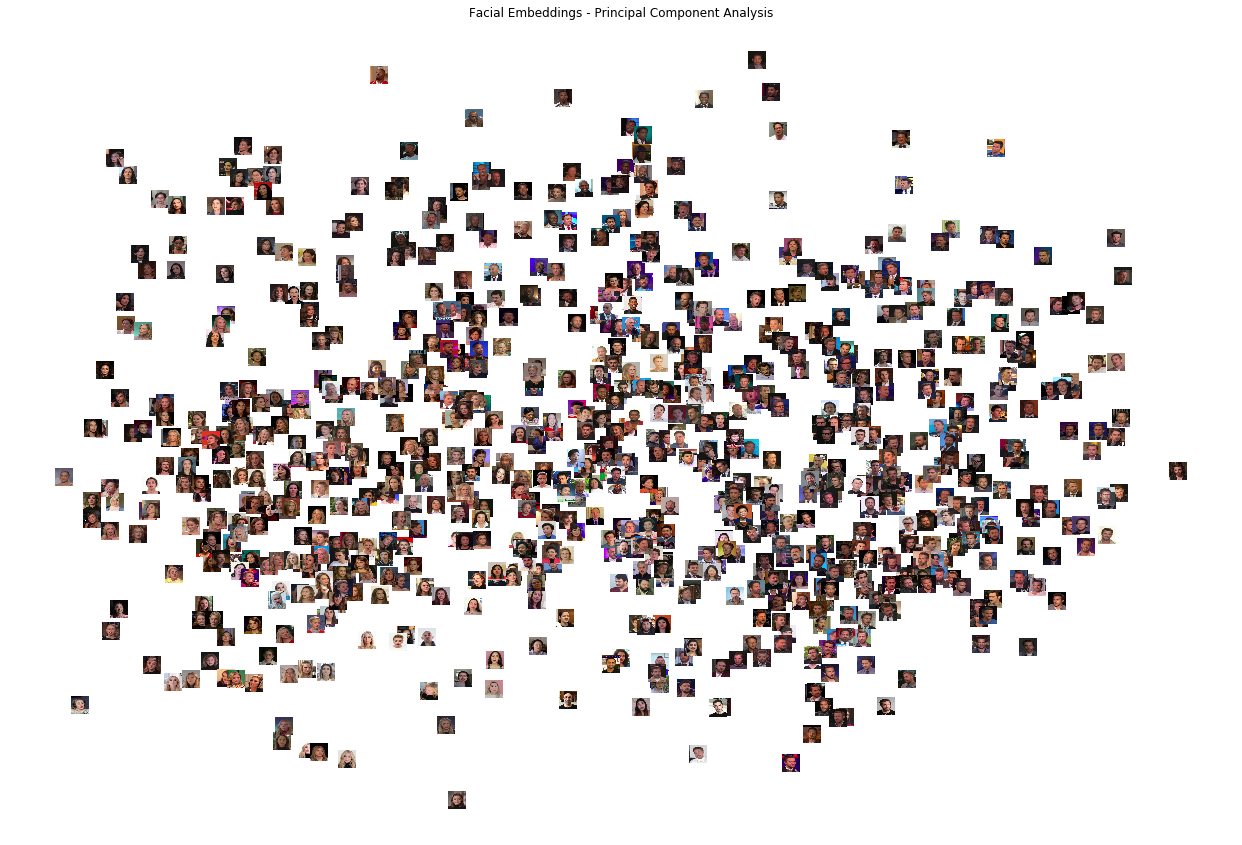

In [51]:
from sklearn.decomposition import PCA

def scatter_thumbnails(data, images, zoom=0.12, colors=None):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data

    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    # add thumbnails :)
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    for i in range(len(images)):
        image = plt.imread(images[i])
        im = OffsetImage(image, zoom=zoom)
        bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
        ab = AnnotationBbox(im, x[i], xycoords='data',
                            frameon=(bboxprops is not None),
                            pad=0.02,
                            bboxprops=bboxprops)
        ax.add_artist(ab)
    return ax

_ = scatter_thumbnails(df.embedding.tolist(), df.face.tolist())
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

In [114]:
%%time
from sklearn.manifold import TSNE
# PCA first to speed it up
# x = PCA(n_components=50).fit_transform()
x = TSNE(perplexity=50, n_components=3).fit_transform(encodings2)

Wall time: 31 s


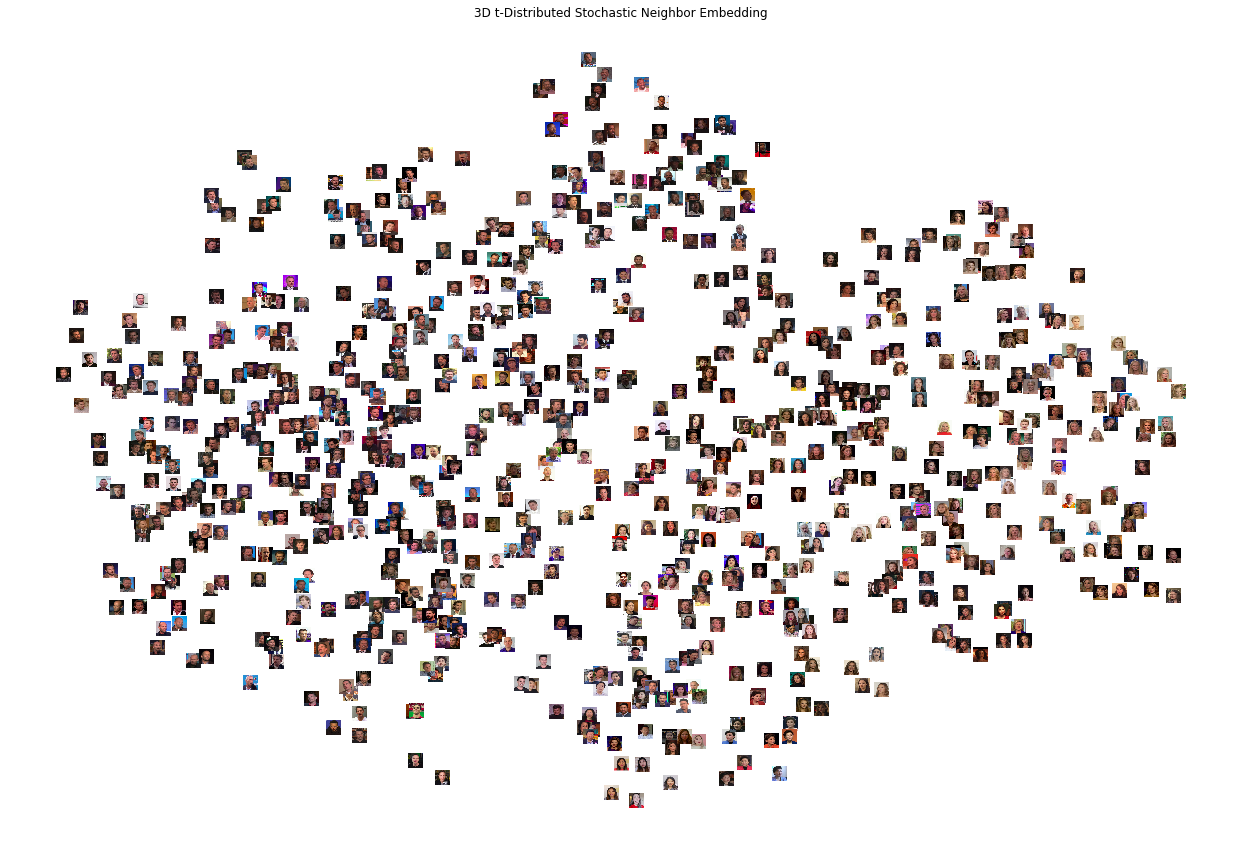

In [115]:
_ = scatter_thumbnails(x, faces2, zoom=0.10)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()

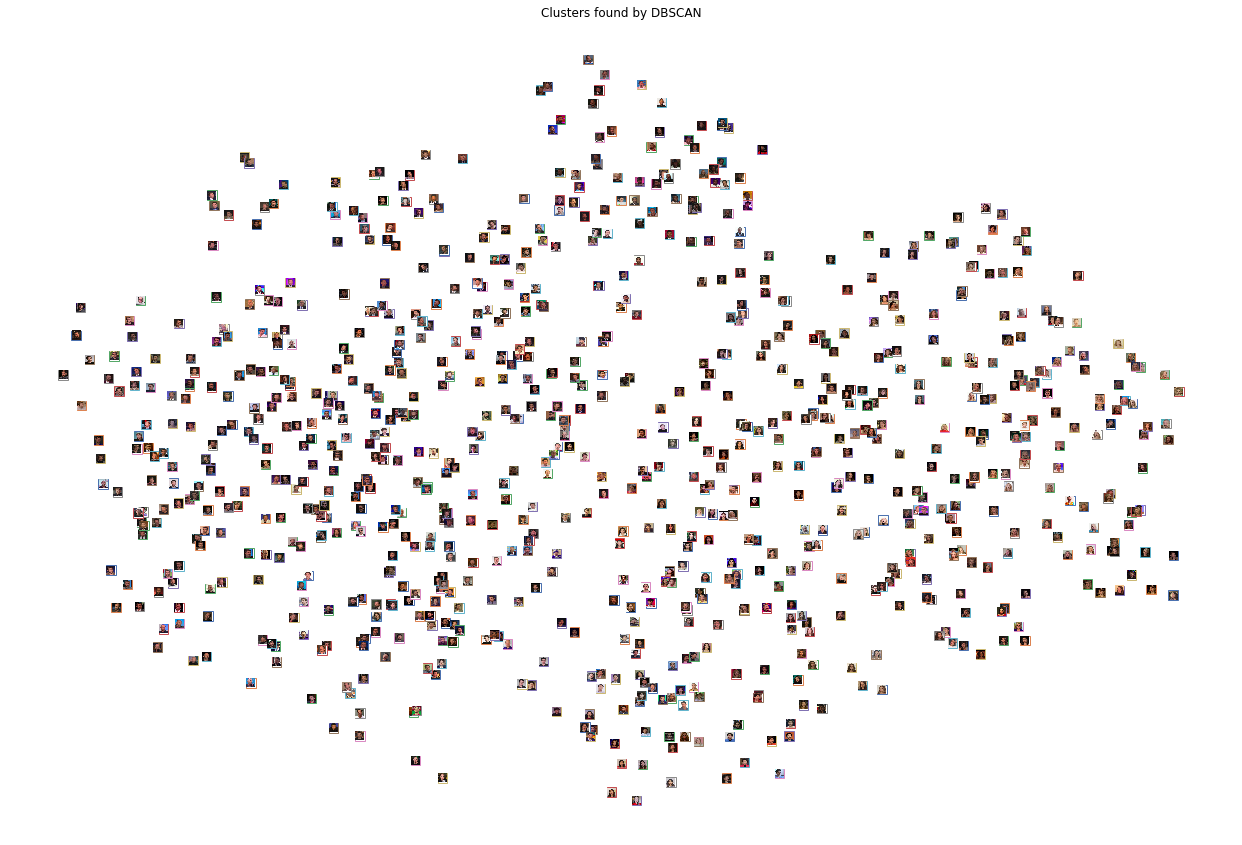

In [116]:
import sklearn.cluster as cluster

def plot_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.max(labels) + 1)
    colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
    ax = scatter_thumbnails(x, faces2, 0.06, colors)
    plt.title(f'Clusters found by {algorithm.__name__}')
    return labels

clusters = plot_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=1.0, min_samples=1)
# df['cluster'] = clusters

In [60]:
# clusters and the number of images on each one of them
ids, counts = np.unique(clusters, return_counts=True)
len(ids)

887

CLUSTERING WITH PY IMAGE SEARCH

In [67]:
import face_recognition

face_rec_enc = []

for p in tqdm(face_files):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(img, model='cnn')
    encoding = face_recognition.face_encodings(img, boxes)
    d = [{"imagePath": p, "loc": box, "encoding": enc}
            for (box, enc) in zip(boxes, encoding)]
    face_rec_enc.extend(d)

100%|██████████| 887/887 [01:19<00:00, 12.34it/s]


In [74]:
data2 = np.array(face_rec_enc)
encodings2 = [d["encoding"] for d in data2]
faces2 = [d["imagePath"] for d in data2]

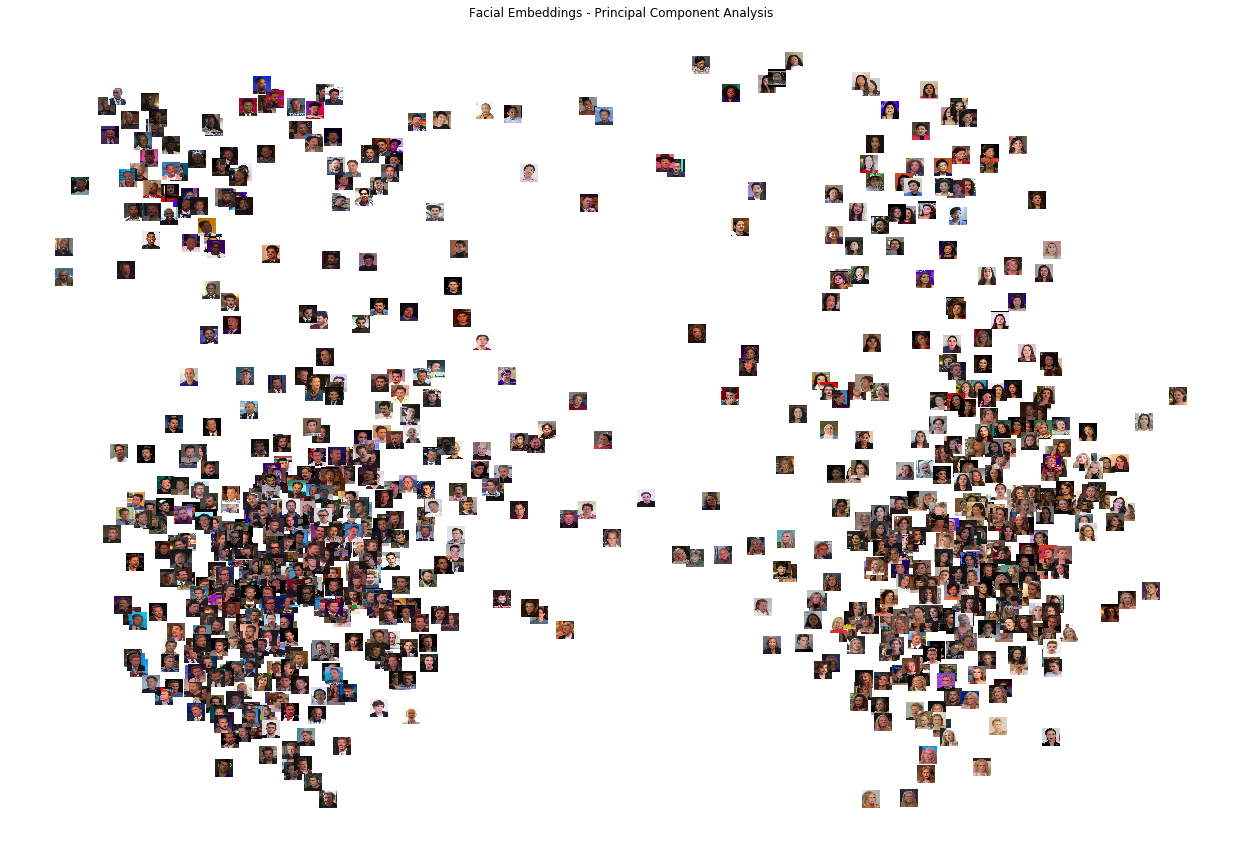

In [76]:
_ = scatter_thumbnails(encodings2, faces2)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

In [73]:
from sklearn.cluster import DBSCAN

clt = DBSCAN(metric="euclidean", n_jobs=-1)
clt.fit(encodings2)

# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] # unique faces: 43


In [145]:
from imutils import build_montages

# loop over the unique face integers
for labelID in labelIDs:
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    
    idxs = np.where(clt.labels_ == labelID)[0]
    print("[INFO] faces for face ID: {} => {}".format(labelID, len(idxs)))
    # idxs = np.random.choice(idxs, size=min(10, len(idxs)), replace=False)
    # # initialize the list of faces to include in the montage
    # faces = []

    # # loop over the sampled indexes
    # for i in idxs:
    #     # load the input image and extract the face ROI
    #     image = cv2.imread(data2[i]["imagePath"])
    #     # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #     (top, right, bottom, left) = data2[i]["loc"]
    #     face = image[top:bottom, left:right]
    #     # force resize the face ROI to 96x96 and then add it to the
    #     # faces montage list
    #     face = cv2.resize(face, (150, 150), cv2.INTER_CUBIC)
    #     faces.append(face)

    # # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    # montage = build_montages(faces, (150, 150), (5, 2))[0]
    # # cv2.imwrite(os.path.join('montages', f'{labelID}.png'), montage)

[INFO] faces for face ID: -1 => 280
[INFO] faces for face ID: 0 => 40
[INFO] faces for face ID: 1 => 16
[INFO] faces for face ID: 2 => 13
[INFO] faces for face ID: 3 => 57
[INFO] faces for face ID: 4 => 47
[INFO] faces for face ID: 5 => 22
[INFO] faces for face ID: 6 => 19
[INFO] faces for face ID: 7 => 10
[INFO] faces for face ID: 8 => 11
[INFO] faces for face ID: 9 => 9
[INFO] faces for face ID: 10 => 12
[INFO] faces for face ID: 11 => 14
[INFO] faces for face ID: 12 => 24
[INFO] faces for face ID: 13 => 21
[INFO] faces for face ID: 14 => 9
[INFO] faces for face ID: 15 => 10
[INFO] faces for face ID: 16 => 5
[INFO] faces for face ID: 17 => 10
[INFO] faces for face ID: 18 => 10
[INFO] faces for face ID: 19 => 9
[INFO] faces for face ID: 20 => 9
[INFO] faces for face ID: 21 => 10
[INFO] faces for face ID: 22 => 10
[INFO] faces for face ID: 23 => 11
[INFO] faces for face ID: 24 => 10
[INFO] faces for face ID: 25 => 11
[INFO] faces for face ID: 26 => 10
[INFO] faces for face ID: 27 => 10

In [139]:
real_vids = [x.split('.')[0] for x in os.listdir('Celeb-real')]
real_vids[:5]

['id0_0000', 'id0_0001', 'id0_0002', 'id0_0003', 'id0_0004']

In [140]:
a = 
for f in vids:
    a.add(f.split('_')[0]+''+f.split('.')[0].split('_')[-1])
[key] = value
for f in vids:
    a.add(f.split('_')[0]+''+f.split('.')[0].split('_')[-1])
len(a)

['id0_id16_0000',
 'id0_id16_0001',
 'id0_id16_0002',
 'id0_id16_0003',
 'id0_id16_0004']

In [141]:
counts = dict()
for name in real_vids:
    for f in fake_vids:
        if name in f:
            if name not in counts:
                counts[name] = 1
            else:
                counts[name] += 1

In [143]:
len

542

In [144]:
tot = 0
for k,v in counts.items():
    if(v <= 500)
    tot += v
print(tot / len(counts))

10.404059040590406


<module 'matplotlib.pyplot' from 'C:\\Users\\sowme\\Anaconda3\\envs\\dfdcpy37-env\\lib\\site-packages\\matplotlib\\pyplot.py'>

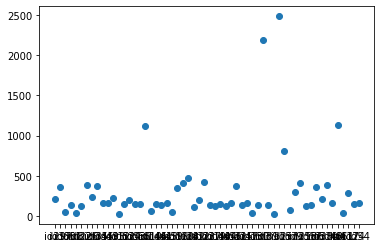

In [133]:
plt.scatter(counts.keys(), counts.values())
plt